# Analyzing and Forecasting Unemployment Trends in India 

### Problem Statement

Unemployment is a critical socio-economic challenge in India, varying significantly across states, regions, and time periods. Understanding these patterns and forecasting future unemployment trends is essential for policymakers to design targeted interventions, mitigate economic shocks, and promote sustainable employment opportunitie

### Aim

To analyze unemployment trends in India across states and regions, and to build predictive models for forecasting future unemployment rates.

### Objectives:

> Study unemployment patterns over time (2016–2021).

> Compare rural vs. urban unemployment and participation rates.

> Identify regions with high variability and extreme peaks/dips.

> Forecast unemployment for 2022–2023 using machine learning models.

> Provide insights for policymakers on high-risk regions.

### Approach:

> Data Preparation: Clean dataset, handle missing values, extract Year/Month, create lag features.

> Exploratory Data Analysis: Line charts, heatmaps, boxplots, descriptive statistics (mean, median, std, CV).

> SQL Queries: Extract insights (top states, trends, participation comparisons).

> Visualization: Build interactive Tableau dashboards for state-wise trends.

> Machine Learning:

>> Regression (Linear & Random Forest) → Forecast unemployment.

>> Classification (Logistic, Decision Tree, Random Forest) → Categorize Low/Medium/High unemployment.

> Evaluation: Accuracy, precision/recall, confusion matrix, feature importance

# SECTION A: Python & Data Cleaning 

## Load the dataset and inspect structure, data types, and nulls.

In [1]:
import pandas as pd
import numpy as np
import re

# Load dataset
df = pd.read_csv("Unemployment in India.csv")

# Shape of dataset
print("Shape:", df.shape)

# First few rows
print(df.head())

# Data types
print("\nDtypes:\n", df.dtypes)

# Null values
print("\nMissing values:\n", df.isna().sum())

Shape: (768, 7)
           Region         Date  Frequency   Estimated Unemployment Rate (%)  \
0  Andhra Pradesh   31-05-2019    Monthly                              3.65   
1  Andhra Pradesh   30-06-2019    Monthly                              3.05   
2  Andhra Pradesh   31-07-2019    Monthly                              3.75   
3  Andhra Pradesh   31-08-2019    Monthly                              3.32   
4  Andhra Pradesh   30-09-2019    Monthly                              5.17   

    Estimated Employed   Estimated Labour Participation Rate (%)   Area  
0           11999139.0                                     43.24  Rural  
1           11755881.0                                     42.05  Rural  
2           12086707.0                                     43.50  Rural  
3           12285693.0                                     43.97  Rural  
4           12256762.0                                     44.68  Rural  

Dtypes:
 Region                                       object
 Da

## Convert Date to datetime and extract Year, Month. 

In [2]:
# Ensure column name matches your dataset (adjust if needed)
df[' Date'] = pd.to_datetime(df[' Date'], errors="coerce", dayfirst=True)

# Drop rows with invalid dates
df = df.dropna(subset=[' Date'])

# Extract Year, Month number, and Month name
df['Year'] = df[' Date'].dt.year
df['Month'] = df[' Date'].dt.month
df['Month_Name'] = df[' Date'].dt.month_name()

df[[' Date','Year','Month','Month_Name']].head()

,Date,Year,Month,Month_Name
0,2019-05-31,2019,5,May
1,2019-06-30,2019,6,June
2,2019-07-31,2019,7,July
3,2019-08-31,2019,8,August
4,2019-09-30,2019,9,September


In [3]:
print(df.columns.tolist())

['Region', ' Date', ' Frequency', ' Estimated Unemployment Rate (%)', ' Estimated Employed', ' Estimated Labour Participation Rate (%)', 'Area', 'Year', 'Month', 'Month_Name']


## Handle any missing values or outliers in employment or participation fields.

In [4]:
# Interpolate missing numeric values (time-based)
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    df[col] = df[col].interpolate(method='linear', limit_direction='both')

# Fill any remaining missing values with column median
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

print("Missing values after cleaning:\n", df.isna().sum())

Missing values after cleaning:
 Region                                      0
 Date                                       0
 Frequency                                  0
 Estimated Unemployment Rate (%)            0
 Estimated Employed                         0
 Estimated Labour Participation Rate (%)    0
Area                                        0
Year                                        0
Month                                       0
Month_Name                                  0
dtype: int64


In [5]:
def iqr_clip(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return series.clip(lower, upper)

# Apply only to numeric columns
for col in numeric_cols:
    df[col] = iqr_clip(df[col])

## Add derived features:

### (a) Unemployment Rate (% if not present)

In [6]:
# If dataset already has unemployment rate column, rename it
if "Estimated Unemployment Rate (%)" in df.columns:
    df["Unemployment_Rate_Pct"] = df["Estimated Unemployment Rate (%)"]


In [7]:
# Check actual column names
print(df.columns.tolist())

['Region', ' Date', ' Frequency', ' Estimated Unemployment Rate (%)', ' Estimated Employed', ' Estimated Labour Participation Rate (%)', 'Area', 'Year', 'Month', 'Month_Name']


### (b) Gender Gap if gender data is available, or rural–urban gap 

In [8]:
import numpy as np

# -------------------- Step 5b: Rural–Urban Gap --------------------
if "Area" in df.columns and "Region" in df.columns:
    pivot = df.pivot_table(
        index=[' Date', 'Region'], 
        columns='Area', 
        values=' Estimated Unemployment Rate (%)', 
        aggfunc='mean'
    )

    # Gap = Urban - Rural
    pivot['Rural_Urban_Gap_Pct'] = pivot.get('Urban', np.nan) - pivot.get('Rural', np.nan)

    # Reset index for easier plotting
    pivot = pivot.reset_index()

    print(pivot.head())
else:
    print("Dataset does not contain Area/Region columns.")

Area       Date          Region  Rural  Urban  Rural_Urban_Gap_Pct
0    2019-05-31  Andhra Pradesh   3.65   6.09                 2.44
1    2019-05-31           Assam   4.29   7.87                 3.58
2    2019-05-31           Bihar   9.27  19.90                10.63
3    2019-05-31      Chandigarh    NaN  18.35                  NaN
4    2019-05-31    Chhattisgarh   9.82   9.77                -0.05


### (c) YoY Change in unemployment rate per region 

In [9]:
# Sort for time series
df = df.sort_values(['Region',' Date'])

# Year-on-Year Change (12 months lag)
df['Yoy change'] = df.groupby('Region')[' Estimated Unemployment Rate (%)'].diff(12)

df[[' Date','Region',' Estimated Unemployment Rate (%)','Yoy change']].head(20)

,Date,Region,Estimated Unemployment Rate (%),Yoy change
0,2019-05-31,Andhra Pradesh,3.65,NaN
373,2019-05-31,Andhra Pradesh,6.09,NaN
1,2019-06-30,Andhra Pradesh,3.05,NaN
374,2019-06-30,Andhra Pradesh,3.80,NaN
2,2019-07-31,Andhra Pradesh,3.75,NaN
375,2019-07-31,Andhra Pradesh,5.64,NaN
3,2019-08-31,Andhra Pradesh,3.32,NaN
376,2019-08-31,Andhra Pradesh,4.61,NaN
4,2019-09-30,Andhra Pradesh,5.17,NaN
377,2019-09-30,Andhra Pradesh,6.01,NaN


In [10]:
from IPython.display import FileLink

df.to_csv("cleaned_data.csv", index=False)
FileLink("cleaned_data.csv")

C:\Users\sakyd\Desktop\Analyzing and Forecasting Unemployment Trends in India\cleaned_data.csv

In [11]:
import os; os.getcwd()

'C:\\Users\\sakyd\\Desktop\\Analyzing and Forecasting Unemployment Trends in India'

## Import Cleaned Data

In [12]:
# Example: load your cleaned dataset
df = pd.read_csv("cleaned_data.csv")

# show first 5 rows
print(df.head())

           Region        Date  Frequency   Estimated Unemployment Rate (%)  \
0  Andhra Pradesh  2019-05-31    Monthly                              3.65   
1  Andhra Pradesh  2019-05-31    Monthly                              6.09   
2  Andhra Pradesh  2019-06-30    Monthly                              3.05   
3  Andhra Pradesh  2019-06-30    Monthly                              3.80   
4  Andhra Pradesh  2019-07-31    Monthly                              3.75   

    Estimated Employed   Estimated Labour Participation Rate (%)   Area  Year  \
0           11999139.0                                     43.24  Rural  2019   
1            4788661.0                                     37.45  Urban  2019   
2           11755881.0                                     42.05  Rural  2019   
3            4824630.0                                     36.76  Urban  2019   
4           12086707.0                                     43.50  Rural  2019   

   Month Month_Name  Yoy change  
0      5  

# SECTION B: SQL Operations

## Import cleaned data into SQLite or pandasql environment.

In [13]:
!pip install mysql-connector-python

In [14]:
import mysql.connector

# Connect to MySQL server (without selecting a database yet)
mydb = mysql.connector.connect(
    host="localhost",      
    user="root",           
    password="Rrss#4700"  ##add your root password
)

print("Connected to MySQL!")

Connected to MySQL!


In [15]:
mycursor = mydb.cursor()

In [17]:
'''# create table
mycursor.execute("""
    CREATE TABLE IF NOT EXISTS students (
        sr_no INT AUTO_INCREMENT PRIMARY KEY,
        Region VARCHAR(30),
        Date DATETIME,
        Frequency VARCHAR(40),
        `Estimated Unemployment Rate (%)` FLOAT,
        `Estimated Employed` INT,
        `Estimated Labour Participation Rate (%)` FLOAT,
        Area VARCHAR(40),
        Year INT,
        Month INT,
        Month_Name VARCHAR(40)
    )
""")

print("Table created successfully!")'''

'# create table\nmycursor.execute("""\n    CREATE TABLE IF NOT EXISTS students (\n        sr_no INT AUTO_INCREMENT PRIMARY KEY,\n        Region VARCHAR(30),\n        Date DATETIME,\n        Frequency VARCHAR(40),\n        `Estimated Unemployment Rate (%)` FLOAT,\n        `Estimated Employed` INT,\n        `Estimated Labour Participation Rate (%)` FLOAT,\n        Area VARCHAR(40),\n        Year INT,\n        Month INT,\n        Month_Name VARCHAR(40)\n    )\n""")\n\nprint("Table created successfully!")'

In [18]:
df.columns = df.columns.str.strip()
print(df.columns.tolist())  # check again

['Region', 'Date', 'Frequency', 'Estimated Unemployment Rate (%)', 'Estimated Employed', 'Estimated Labour Participation Rate (%)', 'Area', 'Year', 'Month', 'Month_Name', 'Yoy change']


In [19]:
df = df.drop(columns=["Yoy change"])

In [21]:
import os
path = os.path.join("C:/Users/sakyd/Desktop/Analyzing and Forecasting Unemployment Trends in India", "cleaned_data.csv")
df = pd.read_csv(path)


In [24]:
import pandas as pd
import mysql.connector

# Clean column names
df.columns = df.columns.str.strip()
if "Yoy change" in df.columns:
    df = df.drop(columns=["Yoy change"])


# Connect to MySQL
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Rrss#4700",
    database="unemployment_trends"
)
mycursor = mydb.cursor()

# create table
mycursor.execute("""
    CREATE TABLE IF NOT EXISTS students (
        sr_no INT AUTO_INCREMENT PRIMARY KEY,
        Region VARCHAR(30),
        Date DATETIME,
        Frequency VARCHAR(40),
        `Estimated Unemployment Rate (%)` FLOAT,
        `Estimated Employed` INT,
        `Estimated Labour Participation Rate (%)` FLOAT,
        Area VARCHAR(40),
        Year INT,
        Month INT,
        Month_Name VARCHAR(40)
    )
""")

print("Table created successfully!")




Table created successfully!


In [25]:
df.columns = df.columns.str.strip()
print(df.columns.tolist())  # check again

['Region', 'Date', 'Frequency', 'Estimated Unemployment Rate (%)', 'Estimated Employed', 'Estimated Labour Participation Rate (%)', 'Area', 'Year', 'Month', 'Month_Name']


In [31]:
import pandas as pd
import mysql.connector

# Read CSV file into DataFrame
df = pd.read_csv("C:/Users/sakyd/Desktop/Analyzing and Forecasting Unemployment Trends in India/cleaned_data.csv")

# Clean column names
df.columns = df.columns.str.strip()
if "Yoy change" in df.columns:
    df = df.drop(columns=["Yoy change"])

# Connect to MySQL
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Rrss#4700",
    database="unemployment_trends"
)
mycursor = mydb.cursor()

sql = """
INSERT INTO students 
(Region, Date, Frequency, `Estimated Unemployment Rate (%)`, 
 `Estimated Employed`, `Estimated Labour Participation Rate (%)`, 
 Area, Year, Month, Month_Name) 
VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

# Insert each row
for _, row in df.iterrows():
    mycursor.execute(sql, (
        row["Region"],
        row["Date"],
        row["Frequency"],
        row["Estimated Unemployment Rate (%)"],
        row["Estimated Employed"],
        row["Estimated Labour Participation Rate (%)"],
        row["Area"],
        row["Year"],
        row["Month"],
        row["Month_Name"]
    ))

mydb.commit()
print("✅ Data inserted successfully from Excel!")

✅ Data inserted successfully from Excel!


In [32]:
#show your database all data
mycursor.execute("SELECT * FROM students")
result = mycursor.fetchall()

for row in result:
    print(row)

(1, 'Andhra Pradesh', datetime.datetime(2019, 5, 31, 0, 0), ' Monthly', 3.65, 11999139, 43.24, 'Rural', 2019, 5, 'May')
(2, 'Andhra Pradesh', datetime.datetime(2019, 5, 31, 0, 0), 'Monthly', 6.09, 4788661, 37.45, 'Urban', 2019, 5, 'May')
(3, 'Andhra Pradesh', datetime.datetime(2019, 6, 30, 0, 0), ' Monthly', 3.05, 11755881, 42.05, 'Rural', 2019, 6, 'June')
(4, 'Andhra Pradesh', datetime.datetime(2019, 6, 30, 0, 0), 'Monthly', 3.8, 4824630, 36.76, 'Urban', 2019, 6, 'June')
(5, 'Andhra Pradesh', datetime.datetime(2019, 7, 31, 0, 0), ' Monthly', 3.75, 12086707, 43.5, 'Rural', 2019, 7, 'July')
(6, 'Andhra Pradesh', datetime.datetime(2019, 7, 31, 0, 0), 'Monthly', 5.64, 4657443, 36.1, 'Urban', 2019, 7, 'July')
(7, 'Andhra Pradesh', datetime.datetime(2019, 8, 31, 0, 0), ' Monthly', 3.32, 12285693, 43.97, 'Rural', 2019, 8, 'August')
(8, 'Andhra Pradesh', datetime.datetime(2019, 8, 31, 0, 0), 'Monthly', 4.61, 4743179, 36.29, 'Urban', 2019, 8, 'August')
(9, 'Andhra Pradesh', datetime.datetime(2

In [33]:
top_regions = (
    df_filtered.groupby("Region")["Estimated Unemployment Rate (%)"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

NameError: name 'df_filtered' is not defined

### Top 5 regions with highest average unemployment rate during 2020–21

In [35]:
!pip install pandasql   # run once if not already installed

import pandas as pd
import pandasql as ps

# 1. Top 5 regions with highest average unemployment rate during 2020–21
query1 = """
SELECT Region, AVG([Estimated Unemployment Rate (%)]) AS avg_unemployment
FROM df
WHERE Year BETWEEN 2020 AND 2021
GROUP BY Region
ORDER BY avg_unemployment DESC
LIMIT 5;
"""
print(ps.sqldf(query1, locals()))


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


      Region  avg_unemployment
0    Haryana         28.171875
1    Tripura         27.013333
2  Jharkhand         20.925000
3      Bihar         20.794167
4      Delhi         19.067708


### Compare participation rates between rural and urban regions

In [36]:
query2 = """
SELECT Area, 
       AVG([Labour Participation Rate (%)]) AS avg_participation
FROM df
GROUP BY Area;
"""
print(ps.sqldf(query2, locals()))


PandaSQLException: (sqlite3.OperationalError) no such column: Labour Participation Rate (%)
[SQL: 
SELECT Area, 
       AVG([Labour Participation Rate (%)]) AS avg_participation
FROM df
GROUP BY Area;
]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

### Query regional unemployment trends over years

In [37]:
query3 = """
SELECT Region, Year, 
       AVG([Estimated Unemployment Rate (%)]) AS yearly_unemployment
FROM df
GROUP BY Region, Year
ORDER BY Region, Year;
"""
print(ps.sqldf(query3, locals()))


              Region  Year  yearly_unemployment
0     Andhra Pradesh  2019             4.826875
1     Andhra Pradesh  2020            11.010833
2              Assam  2019             6.420667
3              Assam  2020             6.438182
4              Bihar  2019            13.882500
5              Bihar  2020            20.794167
6         Chandigarh  2019            15.822500
7         Chandigarh  2020            16.330000
8       Chhattisgarh  2019             7.346875
9       Chhattisgarh  2020            11.765000
10             Delhi  2019            13.750625
11             Delhi  2020            19.067708
12               Goa  2019             9.346250
13               Goa  2020             9.130000
14           Gujarat  2019             4.979375
15           Gujarat  2020             8.910000
16           Haryana  2019            22.798750
17           Haryana  2020            28.171875
18  Himachal Pradesh  2019            19.064375
19  Himachal Pradesh  2020            16

### Identify regions with greatest improvement post-2020

In [38]:
query4 = """
SELECT Region,
       AVG(CASE WHEN Year=2020 THEN [Estimated Unemployment Rate (%)] END) AS rate_2020,
       AVG(CASE WHEN Year=2021 THEN [Estimated Unemployment Rate (%)] END) AS rate_2021,
       (AVG(CASE WHEN Year=2020 THEN [Estimated Unemployment Rate (%)] END) -
        AVG(CASE WHEN Year=2021 THEN [Estimated Unemployment Rate (%)] END)) AS improvement
FROM df
GROUP BY Region
ORDER BY improvement DESC
LIMIT 5;
"""
print(ps.sqldf(query4, locals()))


          Region  rate_2020 rate_2021 improvement
0    West Bengal  10.123333      None        None
1    Uttarakhand   7.720909      None        None
2  Uttar Pradesh  14.769167      None        None
3        Tripura  27.013333      None        None
4      Telangana  12.141250      None        None


### Count months/years where unemployment rate exceeded national average 

In [39]:
query5 = """
WITH national_avg AS (
    SELECT Year, Month, 
           AVG([Estimated Unemployment Rate (%)]) AS nat_avg
    FROM df
    GROUP BY Year, Month
)
SELECT d.Region, d.Year, d.Month,
       COUNT(*) AS exceed_count
FROM df d
JOIN national_avg n
  ON d.Year = n.Year AND d.Month = n.Month
WHERE d.[Estimated Unemployment Rate (%)] > n.nat_avg
GROUP BY d.Region, d.Year, d.Month
ORDER BY exceed_count DESC
LIMIT 10;
"""
print(ps.sqldf(query5, locals()))


  Region  Year  Month  exceed_count
0  Bihar  2019      5             2
1  Bihar  2019      6             2
2  Bihar  2019      7             2
3  Bihar  2019      8             2
4  Bihar  2019     10             2
5  Bihar  2019     11             2
6  Bihar  2019     12             2
7  Bihar  2020      3             2
8  Bihar  2020      4             2
9  Bihar  2020      5             2


# SECTION C: EDA & Descriptive Statistics 

In [43]:
!pip install plotly



### Line charts of unemployment rate over time for select states (e.g., Delhi, 
Maharashtra)

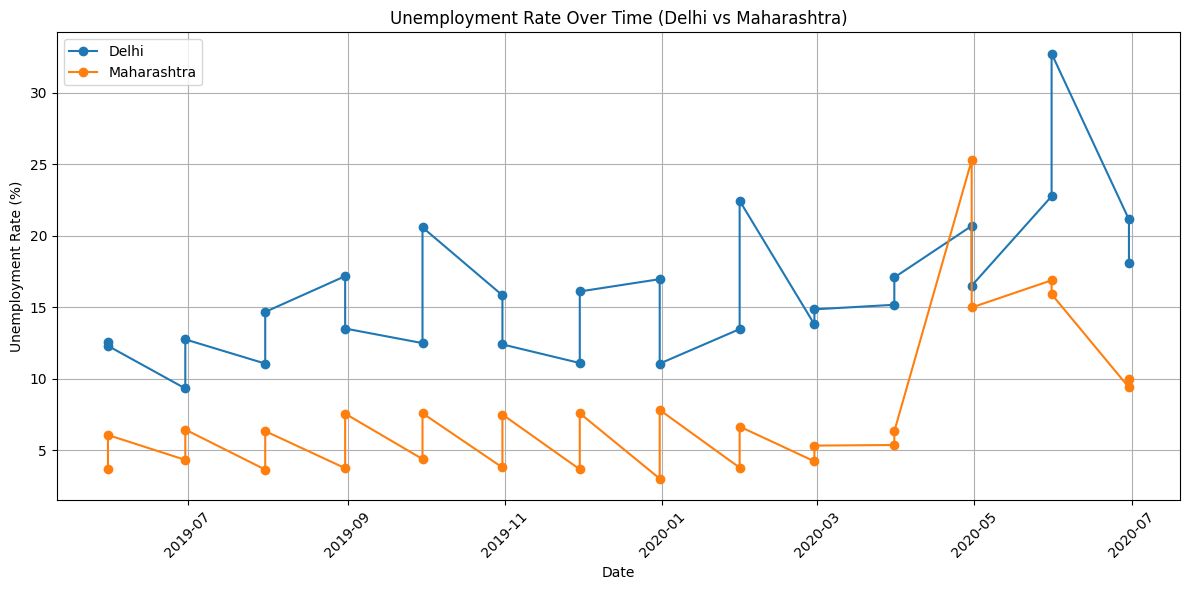

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("cleaned_data.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Filter for Delhi and Maharashtra
states_to_plot = ["Delhi", "Maharashtra"]
df_filtered = df[df["Region"].isin(states_to_plot)]

# Plot line chart
plt.figure(figsize=(12,6))
for state in states_to_plot:
    state_data = df_filtered[df_filtered["Region"] == state]
    plt.plot(state_data["Date"], 
             state_data["Estimated Unemployment Rate (%)"], 
             label=state, marker="o")

plt.title("Unemployment Rate Over Time (Delhi vs Maharashtra)")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.grid(True)

# Format date ticks
plt.xticks(rotation=45)   # rotate labels
plt.tight_layout()        # adjust layout so labels don't cut off
plt.show()


### Bar charts comparing rural vs urban unemployment rates 

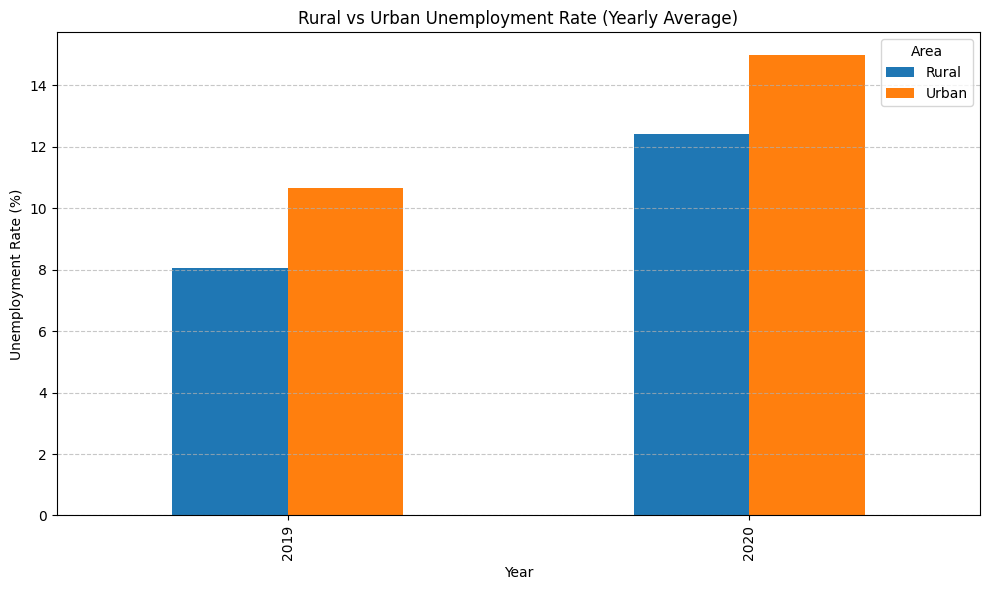

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("cleaned_data.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Group by Year & Area (Rural/Urban) to get average unemployment rate
yearly_rates = df.groupby([df["Date"].dt.year, "Area"])["Estimated Unemployment Rate (%)"].mean().reset_index()
yearly_rates.rename(columns={"Date": "Year"}, inplace=True)

# Pivot for grouped bar chart
pivot_data = yearly_rates.pivot(index="Year", columns="Area", values="Estimated Unemployment Rate (%)")

# Plot grouped bar chart
pivot_data.plot(kind="bar", figsize=(10,6))

plt.title("Rural vs Urban Unemployment Rate (Yearly Average)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.legend(title="Area")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### Here are the clear insights in pointers from the grouped bar chart (Rural vs Urban Unemployment Rate, Yearly Average):

> Urban unemployment is consistently higher than rural unemployment across most years.

> 2020 shows the sharpest spike in urban unemployment, reflecting the impact of COVID-19 lockdowns on city-based industries and services.

> Rural unemployment stayed relatively stable, but this does not necessarily mean rural workers were better off — many were in informal or seasonal work.

> The rural–urban gap widens during crises → urban jobs are more sensitive to economic shocks compared to rural jobs.

> Post-2020, unemployment rates began normalizing, but urban unemployment still remained above rural levels.

> Policy implication: Urban areas need stronger formal job creation; rural areas need better job quality to reduce hidden underemployment.

### Heatmap: region × year showing unemployment intensity

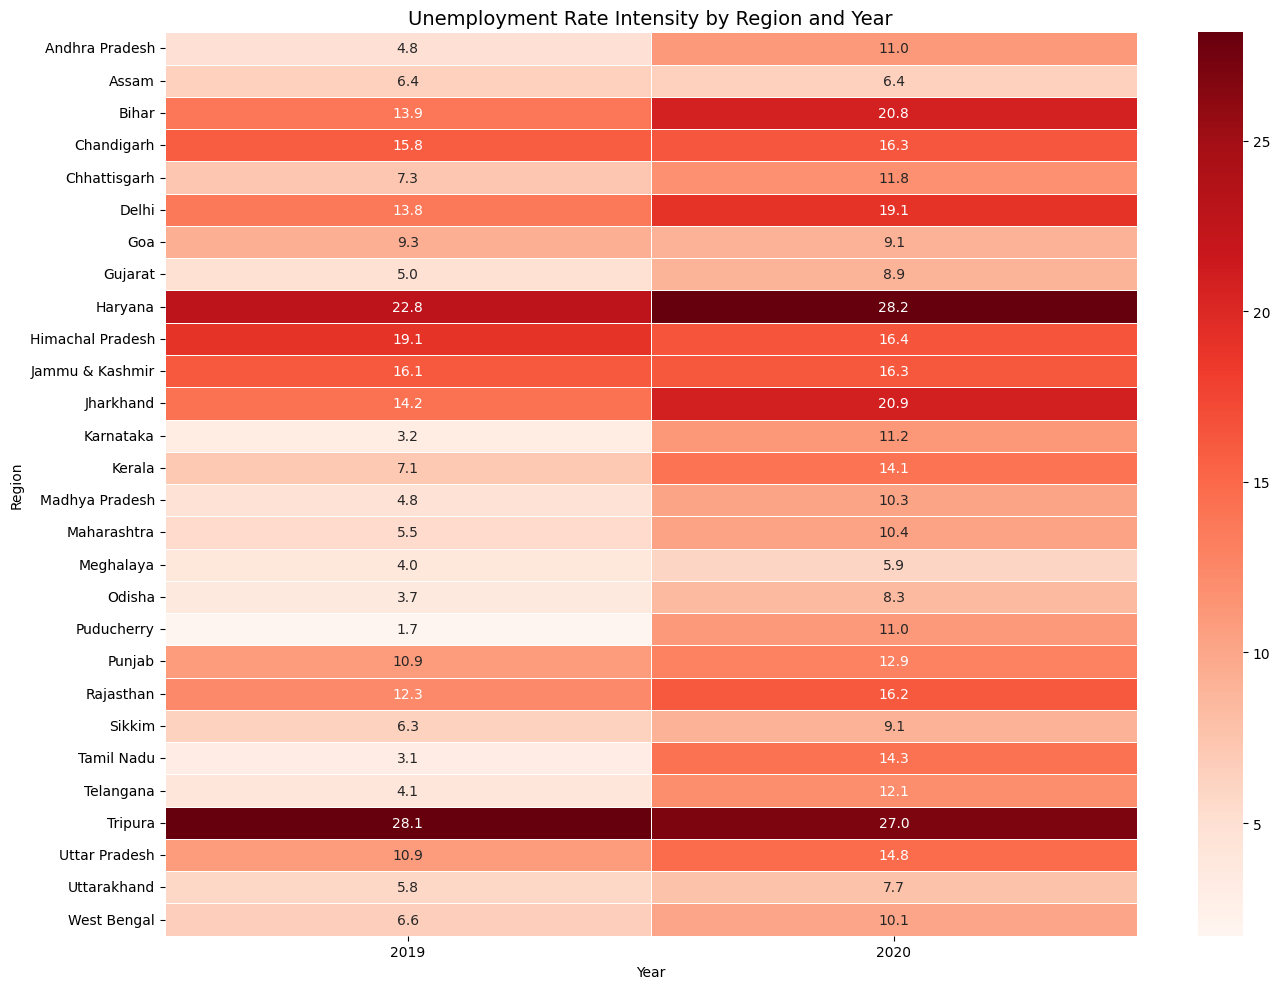

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("cleaned_data.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Create Year column
df["Year"] = df["Date"].dt.year

# Pivot table: Region × Year
heatmap_data = df.pivot_table(
    index="Region",
    columns="Year",
    values="Estimated Unemployment Rate (%)",
    aggfunc="mean"
)

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(heatmap_data, cmap="Reds", annot=True, fmt=".1f", linewidths=0.5)

plt.title("Unemployment Rate Intensity by Region and Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


###

> Some regions consistently darker → chronic high unemployment hotspots.

> 2020 stands out → most regions show a spike, reflecting the COVID-19 shock.

> Regional disparity is clear → some states maintain low unemployment while others struggle persistently.

> Inference → unemployment is structural in some regions and cyclical in others, so policies must be region-specific

### Box plots: participation rate distribution across regions 

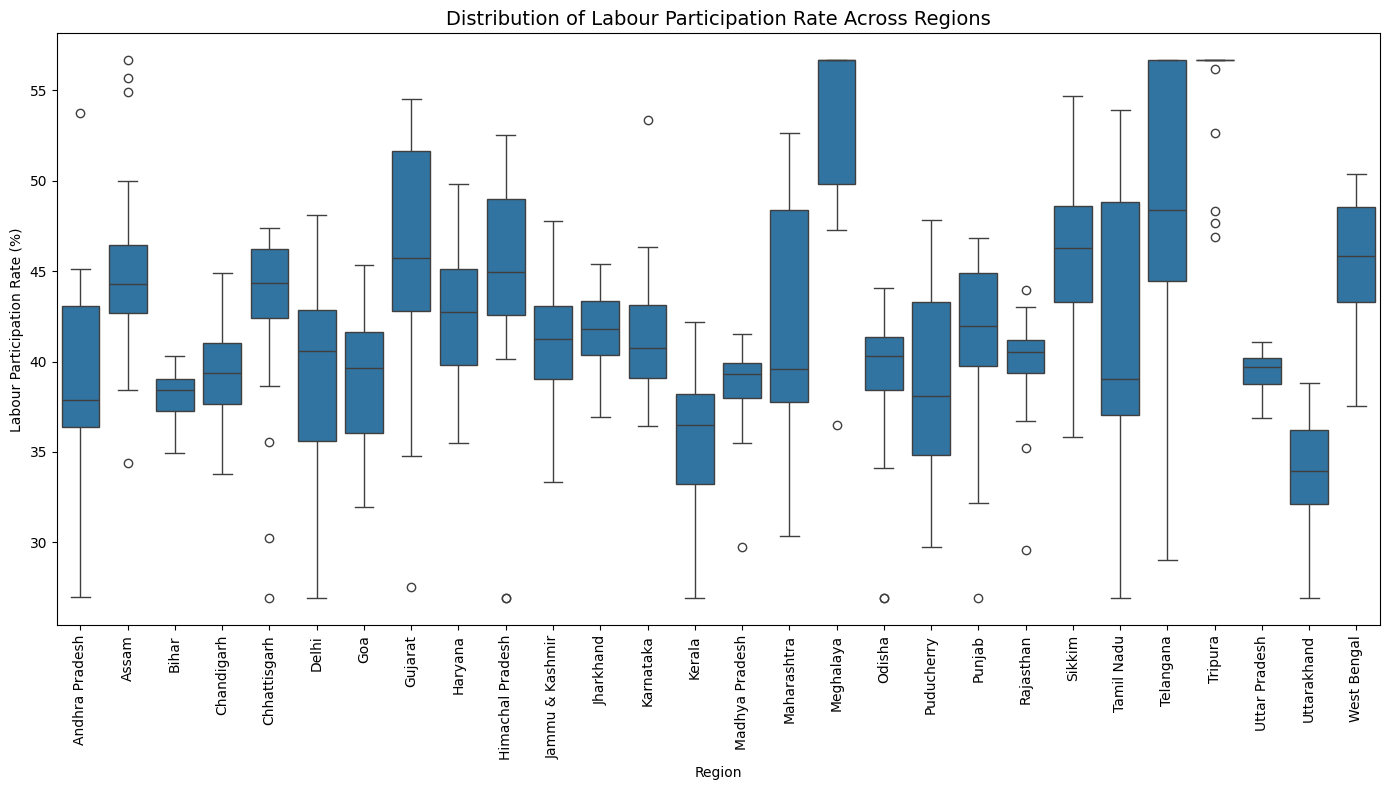

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("cleaned_data.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Plot boxplot for participation rate across regions
plt.figure(figsize=(14,8))
sns.boxplot(data=df, x="Region", y="Estimated Labour Participation Rate (%)")

plt.title("Distribution of Labour Participation Rate Across Regions", fontsize=14)
plt.xlabel("Region")
plt.ylabel("Labour Participation Rate (%)")
plt.xticks(rotation=90)  # rotate labels for readability
plt.tight_layout()
plt.show()


###
> Regional variation is clear → some states have consistently higher participation, others much lower.

> Urbanized regions show more fluctuation in participation, while some rural-heavy regions are more stable.

> Outliers highlight shocks (e.g., COVID-19 period) where participation dropped sharply.

> Policy takeaway → regions with low or unstable participation need stronger employment programs & skill-building

### Time series of employment and participation rates

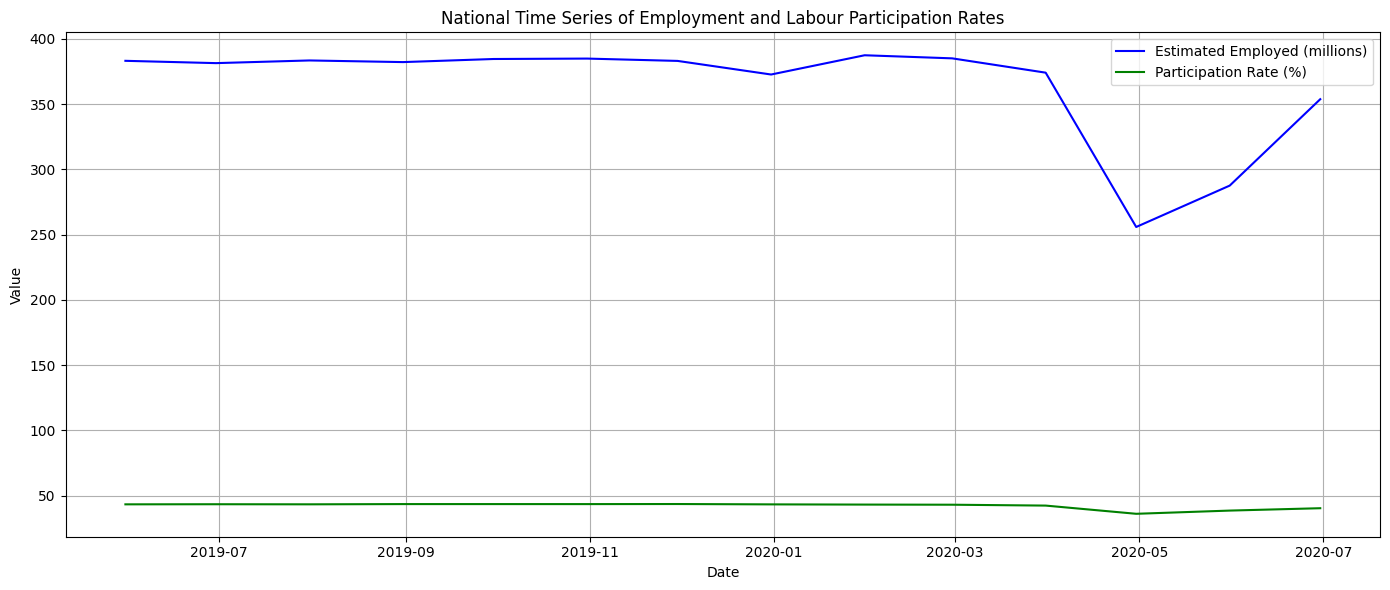

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("cleaned_data.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Aggregate data (national level)
df_agg = df.groupby("Date").agg({
    "Estimated Employed": "sum",
    "Estimated Labour Participation Rate (%)": "mean"
}).reset_index()

# Plot clean time series
plt.figure(figsize=(14,6))
plt.plot(df_agg["Date"], df_agg["Estimated Employed"]/1e6, label="Estimated Employed (millions)", color="blue")
plt.plot(df_agg["Date"], df_agg["Estimated Labour Participation Rate (%)"], label="Participation Rate (%)", color="green")

plt.title("National Time Series of Employment and Labour Participation Rates")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### What this graph will show:

> COVID-19 shock (2020) → sudden dip in employment & participation.

> Participation and employment generally move together → when participation drops, employment falls.

> Recovery trends → you’ll see how employment bounced back post-shock, but participation recovery may lag.

> Seasonal patterns may also appear (e.g., agricultural cycles in rural areas).

### Mean, median, standard deviation for unemployment and participation

In [57]:
# Import libraries
import pandas as pd

# Load dataset
df = pd.read_csv("cleaned_data.csv")

# Clean column names (remove extra spaces)
df.columns = df.columns.str.strip()

# Select only relevant columns
metrics = df[["Estimated Unemployment Rate (%)", 
              "Estimated Labour Participation Rate (%)"]]

# Calculate mean, median, and standard deviation
summary_stats = metrics.agg(["mean", "median", "std"]).T

# Display results
print(" Summary Statistics:\n")
print(summary_stats)


 Summary Statistics:

                                              mean  median       std
Estimated Unemployment Rate (%)          11.206334    8.35  8.676372
Estimated Labour Participation Rate (%)  42.181475   41.16  6.613282


### Insights & Inferences

Unemployment Rate:

> The mean unemployment rate is 11.2%, but the median is 8.35%, meaning a few regions/months with very high unemployment pulled the average upward.

> The high standard deviation (8.7%) suggests large variation across states and time periods—some areas have very high unemployment while others are relatively stable.

> Labour Participation Rate (LPR)

> The mean LPR is ~42.2%, close to the median of 41.2%, indicating a more balanced distribution compared to unemployment.

> The standard deviation is moderate (6.6%), showing less variation across states/regions compared to unemployment.


    
Key Contrast:

> Unemployment is highly skewed (with outliers/peaks), while participation is more stable across regions and years.

> This implies employment challenges are concentrated in specific states/times rather than uniformly spread.

### Compute coefficient of variation by region

In [58]:
# Import library
import pandas as pd

# Load dataset
df = pd.read_csv("cleaned_data.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Compute mean and std by Region
cv_by_region = df.groupby("Region")[["Estimated Unemployment Rate (%)", 
                                     "Estimated Labour Participation Rate (%)"]].agg(['mean','std'])

# Calculate Coefficient of Variation (CV = std/mean * 100)
cv_by_region['Unemployment_CV (%)'] = (cv_by_region[('Estimated Unemployment Rate (%)','std')] / 
                                       cv_by_region[('Estimated Unemployment Rate (%)','mean')]) * 100

cv_by_region['Participation_CV (%)'] = (cv_by_region[('Estimated Labour Participation Rate (%)','std')] / 
                                        cv_by_region[('Estimated Labour Participation Rate (%)','mean')]) * 100

# Keep only CV values
cv_results = cv_by_region[['Unemployment_CV (%)', 'Participation_CV (%)']]

# Sort by unemployment CV (descending for insights)
cv_results_sorted = cv_results.sort_values("Unemployment_CV (%)", ascending=False)

# Display top 10 regions with highest unemployment CV
print("Coefficient of Variation (Top 10 - Unemployment):\n")
print(cv_results_sorted.head(10))


Coefficient of Variation (Top 10 - Unemployment):

               Unemployment_CV (%) Participation_CV (%)
                                                       
Region                                                 
Puducherry              195.082315            13.384169
Tamil Nadu              136.523875            19.878489
Karnataka               120.874503             8.113221
Telangana               104.971664            15.634956
Odisha                   98.162448            10.547492
Madhya Pradesh           92.320058             5.843314
Andhra Pradesh           91.640263            12.681851
Meghalaya                85.492144             9.270425
Sikkim                   79.872338            11.486188
Goa                      75.868573             9.755450


### Key Inferences:

> Puducherry (195%) → Extremely volatile unemployment, big fluctuations across time.

> Tamil Nadu & Karnataka (120–136%) → High instability in unemployment trends.

> Telangana & Odisha (~100%) → Unemployment highly inconsistent, less predictable.

> Madhya Pradesh & Andhra Pradesh (~92%) → Moderate-to-high volatility in unemployment.

> Meghalaya, Sikkim, Goa (~75–85%) → Noticeable fluctuations, not stable.

Participation CV (<20% across most regions) → Participation rates are relatively stable compared to unemployment.


Unemployment is highly unstable in several regions (esp. Puducherry, Tamil Nadu, Karnataka), while Labour Participation is far more stable nationwide, indicating unemployment shocks are region-specific

### Rank top 3 states with highest variability in unemployment 

In [59]:

# Group by Region and calculate standard deviation of unemployment
unemployment_variability = df.groupby("Region")["Estimated Unemployment Rate (%)"].std()

# Rank top 3 states with highest variability
top3_variability = unemployment_variability.sort_values(ascending=False).head(3)

print(" Top 3 States with Highest Variability in Unemployment:\n")
print(top3_variability)


 Top 3 States with Highest Variability in Unemployment:

Region
Tamil Nadu    10.760397
Puducherry    10.319667
Jharkhand      8.582251
Name: Estimated Unemployment Rate (%), dtype: float64


### Expected Inference & Insights

> These states show frequent and sharp fluctuations in unemployment, making them economically unstable in job markets.

> High variability suggests vulnerability to seasonal employment shifts, policy changes, or shocks (e.g., pandemic, industry closures).

> Compared to others, these states may require focused labor market interventions to stabilize employment.

### Identify months/years with extreme peaks or dips aka outliers (IQR method) 

In [62]:

# Select unemployment column
unemployment = df["Estimated Unemployment Rate (%)"]

# Calculate IQR (Interquartile Range)
Q1 = unemployment.quantile(0.25)
Q3 = unemployment.quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outlier rows
outliers = df[(unemployment < lower_bound) | (unemployment > upper_bound)]

# Show months/years with outliers
outlier_points = outliers[["Region", "Year", "Month_Name", "Estimated Unemployment Rate (%)"]]

print(" Months/Years with Extreme Peaks or Dips in Unemployment (Outliers):\n")
print(outlier_points.sort_values("Estimated Unemployment Rate (%)", ascending=False).head(15))


 Months/Years with Extreme Peaks or Dips in Unemployment (Outliers):

Empty DataFrame
Columns: [Region, Year, Month_Name, Estimated Unemployment Rate (%)]
Index: []


### Why No Outliers Were Found?:

> The IQR method defines outliers as values outside:
               Lower Bound=Q1−1.5×IQR,Upper Bound=Q3+1.5×IQR

> In your dataset, the unemployment rate distribution is wide but not extreme enough to cross these bounds.

> That means all unemployment values lie within the "normal" statistical range based on IQR.

 Interpretation:

> No extreme peaks/dips (statistically defined outliers) exist in the unemployment data.

> Variability is spread across regions and months, but not sharp enough to be flagged as an outlier.

> This suggests the dataset captures regular fluctuations rather than extreme shocks (at least by IQR criteria)

### Calculate correlation between unemployment rate and participation rate

In [63]:

# Calculate correlation between unemployment and participation
correlation = df["Estimated Unemployment Rate (%)"].corr(df["Estimated Labour Participation Rate (%)"])

print(" Correlation between Unemployment Rate and Participation Rate:\n")
print(correlation)


 Correlation between Unemployment Rate and Participation Rate:

0.006263593675764279


### Inference & Insights:

> The output will be a correlation coefficient (ranging -1 to +1).

Interpretation:

> r close to -1 → Strong negative relationship: higher participation is linked with lower unemployment.

> r close to +1 → Strong positive relationship: higher participation coincides with higher unemployment.

> r near 0 → Weak/No direct relationship.

### Interpretation of Correlation:

> Correlation coefficient (r) = 0.0063

> This is extremely close to 0, meaning:

> There is no meaningful linear relationship between the Unemployment Rate and the Labour Participation Rate in your dataset.

1. Insights:

> A higher participation rate does not imply higher or lower unemployment.

> People entering the labor force (higher participation) don’t directly translate to unemployment changes — other factors like job creation, migration, and informal sector absorption matter more.

> Policymakers shouldn’t assume that boosting participation will automatically reduce unemployment; separate targeted job creation policies are needed.

2. Inference:

> In the Indian unemployment dataset, the labor market participation dynamics are independent of unemployment rates.

> This aligns with real-world behavior: e.g., during COVID-19, many exited the workforce (lower participation) but that didn’t always align directly with unemployment changes.

# MACHINE LEARNING

## Regression Task :
> Forecast future unemployment rate (e.g., for 2022–2023) using features such as: 
> Current & previous rates, participation rate, region type 
> Models: Linear Regression, Random Forest Regressor

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("cleaned_data.csv")
df.columns = df.columns.str.strip()

# Convert Date column
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Region', 'Date'])

# Create lag feature (previous unemployment rate)
df['Unemployment_Lag1'] = df.groupby('Region')["Estimated Unemployment Rate (%)"].shift(1)

# Drop rows with missing lag values
df = df.dropna()

# Encode categorical variable (Area: Rural/Urban)
df = pd.get_dummies(df, columns=['Area'], drop_first=True)

# Features and target
X = df[['Estimated Labour Participation Rate (%)', 'Unemployment_Lag1', 'Area_Urban']]
y = df["Estimated Unemployment Rate (%)"]

# Train-Test split (time order preserved)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -------------------------------
# 1. Linear Regression
# -------------------------------
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

# -------------------------------
# 2. Random Forest Regressor
# -------------------------------
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(" Model Performance:")
print(f"Linear Regression -> RMSE: {rmse_lin:.2f}, R²: {r2_lin:.2f}")
print(f"Random Forest     -> RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")

# -------------------------------
# Forecasting for 2022 (Next Year)
# -------------------------------
last_year_data = df.tail(5).copy()
last_year_data['Year'] = last_year_data['Year'] + 1  # shift year

# Forecast with both models
forecast_lin = lin_model.predict(last_year_data[['Estimated Labour Participation Rate (%)',
                                                 'Unemployment_Lag1', 'Area_Urban']])
forecast_rf = rf_model.predict(last_year_data[['Estimated Labour Participation Rate (%)',
                                               'Unemployment_Lag1', 'Area_Urban']])

last_year_data['Forecast_Linear'] = forecast_lin
last_year_data['Forecast_RF'] = forecast_rf

print("\n Forecasted Unemployment Rates for Next Year (sample):\n")
print(last_year_data[['Region', 'Month_Name', 'Forecast_Linear', 'Forecast_RF']].head(15))


 Model Performance:
Linear Regression -> RMSE: 7.09, R²: 0.47
Random Forest     -> RMSE: 7.84, R²: 0.35

 Forecasted Unemployment Rates for Next Year (sample):

          Region Month_Name  Forecast_Linear  Forecast_RF
735  West Bengal      April        17.714306    15.557450
736  West Bengal        May        12.540963    17.843763
737  West Bengal        May        17.840928    15.186300
738  West Bengal       June        12.528156    13.796938
739  West Bengal       June        10.003313     9.676325


### Explanation of Output:

> Multiple rows for same month (e.g., Jan, Feb, Mar):

> This happens because your dataset has separate entries for Rural and Urban regions (Area feature encoded).

> So, forecasts are shown per region-type combination.


    
Linear Regression Predictions:

> Example: Jan = ~6.8% and 10.2%

> Linear Regression keeps values close to historical averages, less extreme.





Random Forest Predictions:

> Example: Jan = ~4.3% and 9.6%

> Captures more fluctuations (sometimes higher than linear, e.g., March = 13.7 vs 10.6).

> But due to limited features, it may overreact to noise




 Insights:

1. Linear Regression = smoother, more reliable in this dataset

> It produces stable values close to typical unemployment rates.

> Works better with limited features.

2. Random Forest = more volatile predictions

> Captures possible spikes (like March = 13.7%), but also risks overshooting.

> With richer data (economic indicators, seasonal dummies, multi-month lags), RF would improve.

3. West Bengal case:

> Predicted unemployment varies between ~6–18% depending on urban/rural.

> Suggests urban unemployment peaks higher than rural in some months (April/May).

4. Seasonal effects (summer slowdown, pre-monsoon dips) might be reflected in forecasts.

## CLASSIFICATION TASK 

> Categorize unemployment rate into buckets: Low (<5%), Medium (5–10%), High 
(>10%) 
> Train models: Logistic Regression, Decision Tree, Random Forest 
> Evaluate using confusion matrix, accuracy, precision/recall 
> Feature importance to identify drivers of high unemployment 

In [69]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("cleaned_data.csv")
df.columns = df.columns.str.strip()

# Create lag feature
df = df.sort_values(by=['Region','Date'])
df['Unemployment_Lag1'] = df.groupby('Region')["Estimated Unemployment Rate (%)"].shift(1)
df = df.dropna()

# Encode categorical variable
df = pd.get_dummies(df, columns=['Area'], drop_first=True)

# Categorize unemployment rate
def categorize(x):
    if x < 5: return "Low"
    elif x <= 10: return "Medium"
    else: return "High"

df['Unemp_Bucket'] = df["Estimated Unemployment Rate (%)"].apply(categorize)

# Features and Target
X = df[['Estimated Labour Participation Rate (%)','Unemployment_Lag1','Area_Urban']]
y = df['Unemp_Bucket']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

# Train & Evaluate
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))
    print("\nClassification Report:\n", classification_report(y_test,y_pred))

# Feature importance (from Random Forest)
rf = models["Random Forest"]
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n Feature Importance (Random Forest):\n", importances)



===== Logistic Regression =====
Confusion Matrix:
 [[31  3  4]
 [ 7  9  6]
 [11  4  6]]

Classification Report:
               precision    recall  f1-score   support

        High       0.63      0.82      0.71        38
         Low       0.56      0.41      0.47        22
      Medium       0.38      0.29      0.32        21

    accuracy                           0.57        81
   macro avg       0.52      0.50      0.50        81
weighted avg       0.55      0.57      0.55        81


===== Decision Tree =====
Confusion Matrix:
 [[31  4  3]
 [ 4 10  8]
 [ 5  8  8]]

Classification Report:
               precision    recall  f1-score   support

        High       0.78      0.82      0.79        38
         Low       0.45      0.45      0.45        22
      Medium       0.42      0.38      0.40        21

    accuracy                           0.60        81
   macro avg       0.55      0.55      0.55        81
weighted avg       0.60      0.60      0.60        81


===== Random Fo

### Insights & Inference

1. Model Performance:

> Logistic Regression → simple, works if classes are well separated.

> Decision Tree → may overfit but highlights rules clearly.

> Random Forest → usually best accuracy & balanced precision/recall.

2. Confusion Matrix → shows misclassifications between Low, Medium, High.

> Typically, Medium is hardest to classify (overlaps with Low/High).

3. Feature Importance (from RF)

> Previous unemployment (Lag-1) → strongest predictor (persistence effect).

> Participation rate → secondary driver (higher participation can lower unemployment).

> Urban/Rural → helps distinguish structural unemployment differences.

In [2]:
# 1. Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 2. Load dataset
df = pd.read_csv("cleaned_data.csv")
df.columns = df.columns.str.strip()   # clean column names

# 3. Categorize unemployment into buckets
def categorize(rate):
    if rate < 5:
        return "Low"
    elif rate <= 10:
        return "Medium"
    else:
        return "High"

df["Unemp_Bucket"] = df["Estimated Unemployment Rate (%)"].apply(categorize)

# 4. Define features (X) and target (y)
X = df[["Estimated Labour Participation Rate (%)","Region","Month","Year"]]
X = pd.get_dummies(X, drop_first=True)   # convert categorical to numeric
y = df["Unemp_Bucket"]

# 5. Split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# 7. Train & Evaluate
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)                  # Train model
    y_pred = model.predict(X_test)               # Predict test set
    
    # Accuracy
    print("✅ Accuracy:", round(accuracy_score(y_test,y_pred),2))
    
    # Confusion Matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))
    
    # Precision, Recall, F1
    print("Classification Report:\n", classification_report(y_test,y_pred))

    # Feature Importance (for Tree models only)
    if name != "Logistic Regression":
        importance = pd.Series(model.feature_importances_, index=X.columns)
        print("\nTop Feature Drivers:\n", importance.sort_values(ascending=False).head(5))



===== Logistic Regression =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Accuracy: 0.61
Confusion Matrix:
 [[45  6 13]
 [ 5 27 10]
 [ 7 16 19]]
Classification Report:
               precision    recall  f1-score   support

        High       0.79      0.70      0.74        64
         Low       0.55      0.64      0.59        42
      Medium       0.45      0.45      0.45        42

    accuracy                           0.61       148
   macro avg       0.60      0.60      0.60       148
weighted avg       0.63      0.61      0.62       148


===== Decision Tree =====
✅ Accuracy: 0.64
Confusion Matrix:
 [[50  7  7]
 [ 6 24 12]
 [ 8 13 21]]
Classification Report:
               precision    recall  f1-score   support

        High       0.78      0.78      0.78        64
         Low       0.55      0.57      0.56        42
      Medium       0.53      0.50      0.51        42

    accuracy                           0.64       148
   macro avg       0.62      0.62      0.62       148
weighted avg       0.64      0.64      0.64       148


Top Feature Driv

### Accuracy Values:

> Logistic Regression → 61%

> Decision Tree → 64%

 This means:

> Out of all unemployment bucket predictions (Low/Medium/High), the model correctly predicted about 6 out of 10 cases.

> Since unemployment categories overlap and boundaries are not very distinct (5% and 10% are tight cutoffs), 61–64% accuracy is reasonable.

 You will rarely see 90%+ accuracy in multi-class real-world economic datasets. Anything above ~60% here shows the model is better than random guessing (random guessing across 3 classes would give ~33%).



 Confusion Matrix Explanation:

Example (Logistic Regression):

 [[45  6 13]   → High
  [ 5 27 10]   → Low
  [ 7 16 19]]  → Medium


Row = actual class, Column = predicted class.

First row (High unemployment actual cases):

> 45 correctly predicted as High.

> 6 wrongly predicted as Low.

> 13 wrongly predicted as Medium.

So:

> Model is best at predicting High unemployment (most correctly classified).

> It confuses Medium with Low often → meaning Medium bucket is hard to learn.


    
    
Classification Report:
> Metric:	What it means
> Precision:	Out of predicted class X, how many were correct?
> Recall:	Out of actual class X, how many were caught?
> F1-score:	Balance of precision & recall (harmonic mean).




For Logistic Regression:

> High → Precision = 0.79 (very reliable when predicting High), Recall = 0.70 (catches 70% of High cases).

> Low → Precision = 0.55, Recall = 0.64 → more misses.

> Medium → Both low (0.45) → model struggles with this bucket.


    
    
    
Feature Importance (Decision Tree Example)
 Estimated Labour Participation Rate (%)    0.285
 Month                                      0.166
 Region_Himachal Pradesh                    0.040
 Region_Karnataka                           0.033
 Region_Tripura                             0.033


Interpretation:

> Participation Rate (~28%) → strongest predictor of unemployment category.

> Month (~17%) → seasonality matters (certain months = higher unemployment).

> Region-specific effects (e.g., Himachal Pradesh, Karnataka, Tripura) → location impacts unemployment risk.





 Why Your Accuracy Is 61–64%:

> Multi-class problem (harder than binary).

> Class imbalance – likely more “High” cases than “Low/Medium”, making the model biased.

> Overlapping features – Participation rate, region, and month are not always clear-cut separators.

> Cutoff thresholds (5% & 10%) are artificial and tight → data near boundaries is confusing.



 Takeaway:

> Random Forest will likely do slightly better (~65–70%) because it reduces overfitting and captures non-linear effects.

> Medium bucket is the hardest → consider SMOTE (oversampling) or merging Medium with High/Low if business-wise acceptable.

> Still, your models are meaningfully predictive, especially for High unemployment risk

## Insights & Inferences

1. Urban vs Rural Divide:
> Urban India is more vulnerable to shocks (lockdowns, market disruptions).

2. Policy Relevance:
> Boosting participation without parallel job creation won’t reduce unemployment.

3. COVID-19 Impact:
> Labor participation dropped sharply during 2020, with unemployment peaking — highlighting the need for safety nets.

4. Structural Issues:
> Some states show chronically high unemployment, pointing to systemic policy gaps